In [2]:
import pandas as pd
from pandas_datareader import data as web
from datetime import datetime

def fetch_fred_yield_curve(start="1990-01-01", end=None, out_path="data/raw/fred_yield_curve.csv"):
    
    try:
        df = pd.read_csv(out_path, index_col=0, parse_dates=True)
        print(f"Loading existing file: {out_path}")
        print(f"FRED Yield Curve: {df.shape[0]} rows × {df.shape[1]} cols")
        return df
    except FileNotFoundError:
        print("File not found, downloading data...")

    if end is None:
        end = datetime.today().strftime("%Y-%m-%d")

    fred_tickers = {
        "DGS1MO": "1M",
        "DGS3MO": "3M", 
        "DGS6MO": "6M",
        "DGS1": "1Y",
        "DGS2": "2Y",
        "DGS5": "5Y", 
        "DGS10": "10Y",
        "DGS30": "30Y"
    }

    frames = {}
    for code, label in fred_tickers.items():
        s = web.DataReader(code, "fred", start, end).rename(columns={code: label})
        frames[label] = s

    df = pd.concat(frames.values(), axis=1)
    df = df.ffill().dropna(how="all")  # Forward fill des jours fériés
    df = df.asfreq("B")  # Resampling business days
    df = df.ffill()

    # Export CSV
    df.to_csv(out_path, index=True)
    print(f"FRED Yield Curve: {df.shape[0]} rows × {df.shape[1]} cols")
    print(f"     Saved to: {out_path}")
    
    return df

In [3]:
dataset = fetch_fred_yield_curve(start="1990-01-01", end="2025-09-01")

File not found, downloading data...
FRED Yield Curve: 9303 rows × 8 cols
     Saved to: data/raw/fred_yield_curve.csv


In [4]:
cols_to_drop = []

for col in dataset.columns:
    print(dataset[col].isna().sum())
    if dataset[col].isna().sum() > 0:
        cols_to_drop.append(col)

dataset.drop(cols_to_drop, axis=1, inplace=True)

print(dataset.shape)

3020
0
0
0
0
0
0
0
(9303, 7)


In [5]:
def preprocess_yield_curve(df):
    """
    Preprocess yield curve data with winsorization and two types of normalization
    
    Args:
        df (pd.DataFrame): Raw yield curve dataset
        
    Returns:
        tuple: (cross_section_zscore_df, column_zscore_df)
    """
    # Winsorize each column at 0.1% and 99.9%
    df_winsorized = df.copy()
    for col in df.columns:
        lower = df[col].quantile(0.001)
        upper = df[col].quantile(0.999)
        df_winsorized[col] = df[col].clip(lower=lower, upper=upper)
    
    # A) Cross-section z-score (standardize each date/row)
    cross_section_zscore = (df_winsorized.sub(df_winsorized.mean(axis=1), axis=0)
                           .div(df_winsorized.std(axis=1), axis=0))
    
    # B) Column-wise z-score (standardize each maturity/column)
    column_zscore = (df_winsorized - df_winsorized.mean())/ df_winsorized.std()
    
    return cross_section_zscore, column_zscore

cross_section_zscore_df, column_zscore_df = preprocess_yield_curve(dataset)

print("Cross-section z-score shape:", cross_section_zscore_df.shape) 
print("Column-wise z-score shape:", column_zscore_df.shape)

Cross-section z-score shape: (9303, 7)
Column-wise z-score shape: (9303, 7)


In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Perform PCA on both normalizations
pca_cross = PCA()
pca_col = PCA()

pca_cross_transformed = pca_cross.fit_transform(cross_section_zscore_df)
pca_col_transformed = pca_col.fit_transform(column_zscore_df)

# Analyze explained variance ratios
print("\nPCA Analysis for Cross-sectional Z-scores:")
print("Explained variance ratios:", pca_cross.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca_cross.explained_variance_ratio_))

print("\nPCA Analysis for Column-wise Z-scores:")
print("Explained variance ratios:", pca_col.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca_col.explained_variance_ratio_))


PCA Analysis for Cross-sectional Z-scores:
Explained variance ratios: [7.25298298e-01 2.06188051e-01 4.84905423e-02 1.24421198e-02
 5.47500675e-03 2.10598191e-03 7.15629809e-17]
Cumulative explained variance: [0.7252983  0.93148635 0.97997689 0.99241901 0.99789402 1.
 1.        ]

PCA Analysis for Column-wise Z-scores:
Explained variance ratios: [9.24909451e-01 7.07593620e-02 3.62575141e-03 4.54235203e-04
 1.65667244e-04 5.33666127e-05 3.21668834e-05]
Cumulative explained variance: [0.92490945 0.99566881 0.99929456 0.9997488  0.99991447 0.99996783
 1.        ]


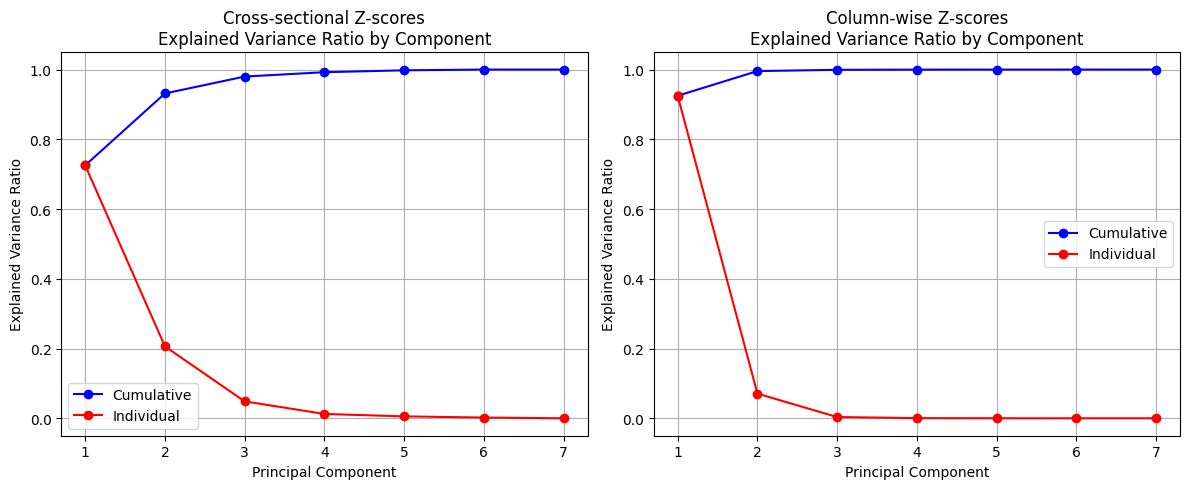


Number of components needed to explain 95% of variance:
Cross-sectional Z-scores: 3 components
Column-wise Z-scores: 2 components


In [17]:
# Plot explained variance ratios
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(pca_cross.explained_variance_ratio_) + 1), 
         np.cumsum(pca_cross.explained_variance_ratio_), 
         'b-o', label='Cumulative')
plt.plot(range(1, len(pca_cross.explained_variance_ratio_) + 1),
         pca_cross.explained_variance_ratio_,
         'r-o', label='Individual')
plt.title('Cross-sectional Z-scores\nExplained Variance Ratio by Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(pca_col.explained_variance_ratio_) + 1),
         np.cumsum(pca_col.explained_variance_ratio_),
         'b-o', label='Cumulative')
plt.plot(range(1, len(pca_col.explained_variance_ratio_) + 1),
         pca_col.explained_variance_ratio_,
         'r-o', label='Individual')
plt.title('Column-wise Z-scores\nExplained Variance Ratio by Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Print components needed to explain 95% of variance
def components_for_variance(explained_variance_ratio, threshold=0.95):
    cumsum = np.cumsum(explained_variance_ratio)
    return np.argmax(cumsum >= threshold) + 1

print("\nNumber of components needed to explain 95% of variance:")
print(f"Cross-sectional Z-scores: {components_for_variance(pca_cross.explained_variance_ratio_)} components")
print(f"Column-wise Z-scores: {components_for_variance(pca_col.explained_variance_ratio_)} components")


In [19]:
from src.models.ae_kan import KANAutoencoder

kan_model = KANAutoencoder(
    input_dim=len(pca_cross.explained_variance_ratio_),  # Number of yield curve points
    k=components_for_variance(pca_cross.explained_variance_ratio_),  # Number of components for 95% variance
    hidden_dims=[32, 16],

    basis_type = "spline",
    M = 16,
    poly_degree = 5,
    xmin = -3.5,
    xmax = 3.5,
    dropout_p = 0.05,
    use_silu = True,

    loss_type = "mse",
    huber_delta = 1,

    lambda_alpha = 0.0001,
    lambda_group = 0.00001,
    lambda_tv = 0.0001,
    lambda_poly_decay = 0.00001,

    use_global_skip = False,
    use_skip = False,
    skip_init = "zeros",
    skip_gain = 1,
    lambda_skip_l2 = 0,
    max_skip_gain = 1
)

In [21]:
import torch
import sys
sys.path.append('src')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"Memory available: {torch.cuda.mem_get_info()[0] / 1024**3:.1f} GB")

print(f"Device : {device}")

Device : cpu


In [ ]:
history = kan_model.fit(
    X_train=column_zscore_df.values,
    W_train=None,
    M_train=None,
    X_val=None,
    W_val=None,
    M_val=None,
    validation_split=0.2,
    epochs= 100,
    batch_size=64,
    learning_rate=0.001,
    weight_decay=0.00001,
    patience=10,
    verbose=True,
    lambda_reg=0.0001,
    device=device,
    use_weighted_loss=True
)

⚠️  Utilisation du split aléatoire (validation_split=0.2)
   💡 Recommandation: fournir X_val pour données temporelles


TypeError: 'int' object is not callable